# Importing libraries

In [1]:
experiment = True 

parameters = {
    'task': 'T1_to_FCD', # 'T1_to_FCD', 'T2_to_FCD', 'T3_to_FCD'
    'name_exp': 'T1 to FCD, ellipse mask, weighted ce loss',
    'loss_type': 'weighted ce', # 'dice', 'dice+ce', 'weighted ce'
    'num_encoding_blocks': 2,
    'out_channels_first_layer': 1,
    'num_epochs': 40}

# Creating new experiment in Comet.ml
if experiment:
    from comet_ml import Experiment
    experiment = Experiment(
        api_key="VCyOxE7IjP9abOTTSwvn2gfs4",
        project_name="fcd-detection",
        workspace="mrugnivenko",)

    experiment.log_parameters(parameters)

import os
import sys
import glob
import torch
import torchio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mrugnivenko/fcd-detection/3faf29a6752e4cdb99e938d1dbd6ef86



In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine_pirogov as routine
imp.reload(routine)
from utils.routine_pirogov import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

import utils.metrics_deep_mind as metrics_deep_mind
imp.reload(metrics_deep_mind)
from utils.metrics_deep_mind import *

# Loading dataset

In [3]:
paths_to_all_files = pd.read_csv('Pirogov_paths.csv', index_col = 0)

In [4]:
paths_to_all_files.head()

,Subject,T1,T2,T3,fcd_mask
0,fcd_10,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
1,fcd_08,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
2,fcd_07,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
3,fcd_03,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...
4,fcd_23,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/fcd_brains/fcd_...,../datasets/croped_new_dataset/masks/mask_fcd_...


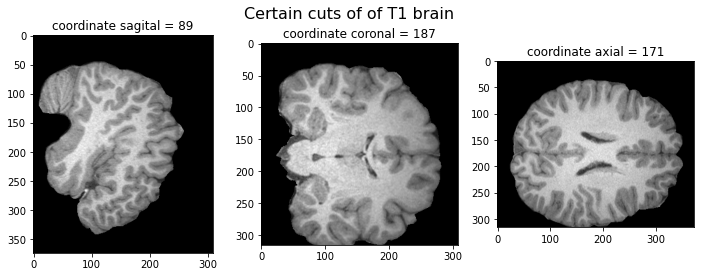

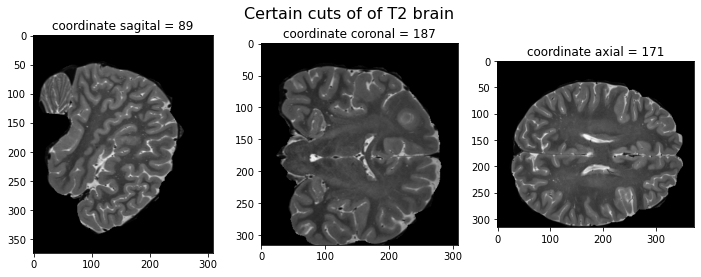

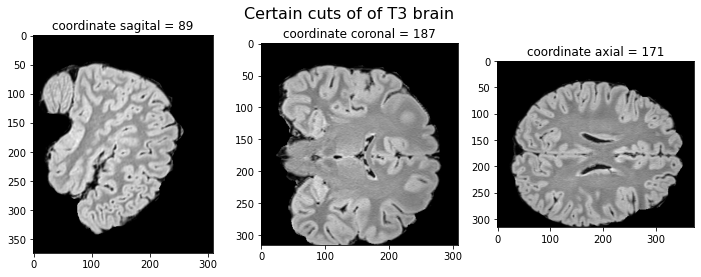

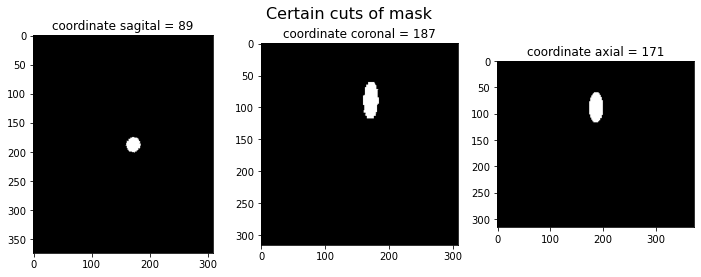

In [49]:
mask = load_nii_to_array(paths_to_all_files.loc[0].fcd_mask)
center_mask = get_center_coord_of_bb(mask)

plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T1), center_mask, 'of T1 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T2), center_mask, 'of T2 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].T3), center_mask, 'of T3 brain')
plot_certain_cuts(load_nii_to_array(paths_to_all_files.loc[0].fcd_mask), center_mask, 'mask')

In [5]:
ratio = True
if ratio:
    number_of_ones = 0
    for mask_path in paths_to_all_files.fcd_mask.values.tolist():
        mask = load_nii_to_array(mask_path)
        mask_size = mask.shape[0]*mask.shape[1]*mask.shape[2]
        number_of_ones += mask.sum()
    ratio = int(mask_size*len(paths_to_all_files.fcd_mask.values.tolist())/number_of_ones)
    print(f'Ratio of ones is {ratio}')

Ratio of ones is 860


# Making transform

In [6]:
modality = parameters['task'].split('_')[0]
landmarks_path = 'landmarks/Pirogov_' + modality + '_landmarks.npy'
landmark = np.load(landmarks_path)

training_transform = Compose([
        HistogramStandardization(landmarks={modality: landmark}),
        ZNormalization(masking_method=ZNormalization.mean),
        CropOrPad((316, 376, 308))
    ])

validation_transform = Compose([
        HistogramStandardization(landmarks={modality: landmark}),
        ZNormalization(masking_method=ZNormalization.mean),
        CropOrPad((316, 376, 308))
    ])

In [7]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(paths_to_all_files))))

In [8]:
training_loader, validation_loader = get_loaders(paths_to_all_files,
                                                 cv_splits[0],
                                                 training_transform,
                                                 validation_transform, modality = modality)

Training set: 18 subjects
Validation set: 8 subjects
Modality is T1


In [9]:
torch.cuda.empty_cache()

In [10]:
!nvidia-smi

Sun May 16 13:04:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   46C    P2   175W / 280W |   8211MiB / 11178MiB |     69%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   50C    P2   242W / 280W |   9781MiB / 11178MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [11]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [13]:
model, optimizer, scheduler = get_model_and_optimizer(device, 
                                                      num_encoding_blocks = parameters['num_encoding_blocks'], 
                                                      out_channels_first_layer = parameters['out_channels_first_layer'])

epoch = '10'
name_exp = parameters['name_exp'] 
exp = name_exp.replace(',', '').replace(' ', '_') + '_epoch_' + epoch + '.pth'
model.load_state_dict(torch.load('weights/' + exp))

<All keys matched successfully>

Epoch 40 of 40 took 6737.875s
  training loss (in-iteration): 	14.746293
  validation loss: 			13.930816


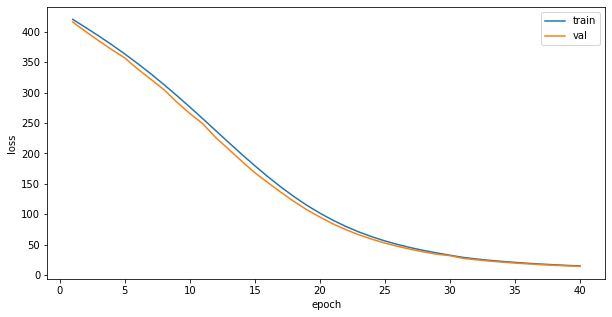

In [14]:
torch.cuda.empty_cache()

name_exp = parameters['name_exp'] 

if experiment:
    experiment.set_name(parameters['name_exp'])

training_params =  {
    'num_epochs': parameters['num_epochs'], 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ratio' : ratio,
    'experiment': experiment,
    'weights_stem':name_exp.replace(',', '').replace(' ', '_'),
    'verbose':True,
    'save_epoch':1,
    'loss_type': parameters['loss_type'],
    'task': parameters['task']
}

train(**training_params)

In [15]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/mrugnivenko/fcd-detection/3faf29a6752e4cdb99e938d1dbd6ef86
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [72]           : (13.248604774475098, 426.82855224609375)
COMET INFO:     train_loss [720]    : (14.597854614257812, 426.82855224609375)
COMET INFO:     validate_loss [328] : (13.874323209126791, 427.1737060546875)
COMET INFO:   Others:
COMET INFO:     Name : T1 to FCD, ellipse mask, weighted ce loss
COMET INFO:   Parameters:
COMET INFO:     loss_type                : weighted ce
COMET INFO:     name_exp                 : T1 to FCD, ellipse mask, weighted ce loss
COMET INFO:     num_encoding_blocks      : 2
COMET INFO:     num_epochs               : 40
COMET INFO:     out_channels_first_layer : 1
COMET INFO:     task           

In [16]:
model, _, _ = get_model_and_optimizer(device, 
                                      num_encoding_blocks = parameters['num_encoding_blocks'], 
                                      out_channels_first_layer = parameters['out_channels_first_layer'])
epoch = '40'
exp = name_exp.replace(',', '').replace(' ', '_') + '_epoch_' + epoch + '.pth'
model.load_state_dict(torch.load('weights/' + exp))

<All keys matched successfully>

In [17]:
model.eval()

dice_scores = []
iou_scores = []
average_distances_gt_to_pred = []
average_distances_pred_to_gt = []

for batch in tqdm(validation_loader):
    inputs, targets = prepare_batch(batch, device, task = parameters['task'])
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        prediction = probabilities.argmax(dim = 1)[0]
        ground_true  = targets[0,0,:]
        
    dice_scores.append((get_dice_score(targets, probabilities)*torch.tensor([1, 0]).float().to(device)).sum().cpu().detach().numpy())
    iou_scores.append(get_iou_score(prediction.cpu().detach().numpy(), ground_true.cpu().detach().numpy()))
    
    average_distance_gt_to_pred, average_distance_pred_to_gt = compute_average_surface_distance(
        compute_surface_distances(
        ground_true.cpu().numpy().astype(np.uint8),
        prediction.cpu().numpy(), 
        spacing_mm=(1,1,1)
        )
    )
    
    average_distances_gt_to_pred.append(average_distance_gt_to_pred)
    average_distances_pred_to_gt.append(average_distance_pred_to_gt)
    
print('Mean dice score = ', np.mean(dice_scores))
print('Mean IoU score = ', np.mean(iou_scores))
print('Mean average distance gt to prediction = ', np.mean([x for x in average_distances_gt_to_pred if  np.isnan(x)== False]))
print('Mean average distance prediction to gt = ', np.mean([x for x in average_distances_pred_to_gt if x != np.inf]))

100%|██████████| 8/8 [02:37<00:00, 19.74s/it]

Mean dice score =  0.0019054195201412857
Mean IoU score =  0.000992373944564727
Mean average distance gt to prediction =  69.30473809668962
Mean average distance prediction to gt =  210.60891211987558


In [18]:
model.eval()

batch = next(iter(validation_loader))
inputs, targets = prepare_batch(batch, device, task = parameters['task'])
with torch.no_grad():
    logits = forward(model, inputs)
    probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
pred = probabilities.argmax(dim = 1)[0]
seg  = targets[0,0,:]

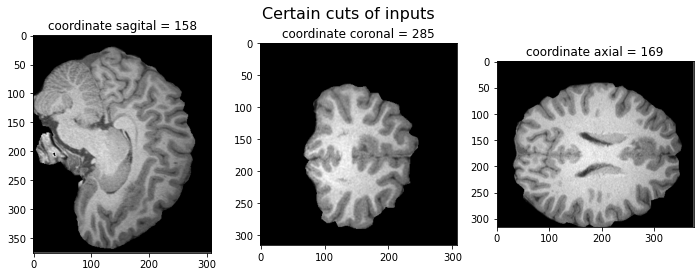

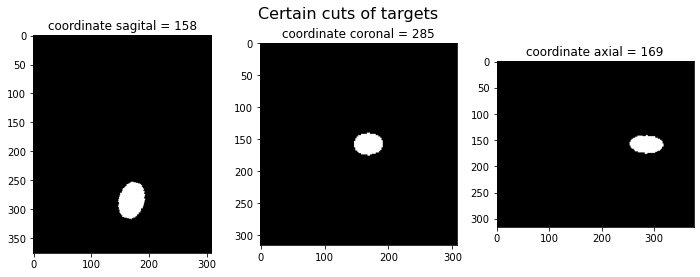

In [19]:
plot_certain_cuts(inputs[0,0,:].cpu().detach().numpy(), 
                  get_center_coord_of_bb(targets[0,0,:].cpu().detach().numpy()), 'inputs')
plot_certain_cuts(targets[0,0,:].cpu().detach().numpy() 
                  , get_center_coord_of_bb(targets[0,0,:].cpu().detach().numpy()), 'targets')

In [20]:
from ipywidgets import IntSlider, interact

def plot_gt_pred(gt_slice, pred_slice, cmap = 'gray'):


    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True, figsize = (10, 10))
    
    ax0.imshow(gt_slice, cmap=cmap)
    ax0.set_title('Ground true')
    ax0.grid(True)

    ax1.imshow(pred_slice, cmap=cmap)
    ax1.set_title('Prediction')
    ax1.grid(True)

    plt.show()
    
def vary_coordinate(sagital, coronal, axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_gt_pred(gt[sagital,:,:], prediction[sagital,:,:])
    if axis == 'coronal':
        plot_gt_pred(gt[:,coronal ,:], prediction[:,coronal ,:] )
    if axis == 'axial':
        plot_gt_pred(gt[:,:, axial], prediction[:,:, axial])
    
def slider(gt, pred):
    
    sld_sagital = IntSlider(min=0, max=prediction.shape[0]-1, step=1, continuous_update=True)
    sld_coronal = IntSlider(min=0, max=prediction.shape[1]-1, step=1, continuous_update=True)
    sld_axial   = IntSlider(min=0, max=prediction.shape[2]-1, step=1, continuous_update=True)
    
    interact(vary_coordinate, 
         sagital = sld_sagital,
         coronal = sld_coronal,
         axial = sld_axial,
         axis = 'axial');

In [25]:
prediction = 1 - pred.cpu().detach().numpy()
gt = seg.cpu().detach().numpy()

sld_sagital = IntSlider(min=0, max=pred.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=pred.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=pred.shape[2]-1, step=1, continuous_update=True)
    
interact(vary_coordinate, 
     sagital = sld_sagital,
     coronal = sld_coronal,
     axial = sld_axial,
     axis = 'axial');

interactive(children=(IntSlider(value=0, description='sagital', max=315), IntSlider(value=0, description='coro…